# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
from pyspark.sql import SparkSession
import pyspark.sql.functions
from pyspark.sql.functions import udf, avg, col, collect_list, count, when
from pyspark.sql.types import StringType
import datetime
import numpy as np
import pandas as pd
import time

from pyspark.ml.classification import LogisticRegression, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import matplotlib.pyplot as plt

In [2]:
# create a Spark session
spark = SparkSession.builder.appName("Sparkify").getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
sparkify_data = 'mini_sparkify_event_data.json'
df = spark.read.json(sparkify_data)

In [4]:
#Let's see how many rows and columns are in this dataset
print("Number of Rows: " + str(df.count()))
print("Number of Columns: " + str(len(df.columns)))

Number of Rows: 286500
Number of Columns: 18


In [5]:
#Let's get an idea on the schema of this dataset
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [6]:
#Show 5 rows of the data to give us an idea of what the data actually looks like
df.limit(5).toPandas().head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30


Now that I have loaded the dataset, I am ready to clean the data<br>
Here is a quick summary of some of the cleaning I will do on the data: <br>
1. Check for records that have missing userId<br>
2. Check for records that have null sessionId<br>
3. Check for records that have missing gender inputs <br>
4. Check distribution of columns to remove any possible columns that may not have variation (single valued columns)<br>
5. Convert ts to proper timestamp format<br>
6. Convert registration to proper timestamp format<br>
7. Split location column into two new columns - userCity, and userState
8. Remove userAgent, method, location column as they do not appear to be relevant for my analysis

In [7]:
#Checking for records that have missing userId
df = df.filter(df.userId != "")

In [8]:
#Checking for records that have null sessionId
df = df.dropna(how = "any", subset = ["sessionId"])

In [9]:
#Checking for records that have missing gender input
df = df.filter(df.gender != "")

In [10]:
#Checking distribution of columns to remove any possible columns that may not have much relevant variations
for column in df.columns:
    print(df.groupBy(column).count().show())

+--------------------+-----+
|              artist|count|
+--------------------+-----+
|      The Black Keys| 1125|
|         Silverstein|   60|
|           Kate Nash|   99|
|        Yann Tiersen|  139|
|    Jane's Addiction|   68|
|          Tim Hughes|   39|
|          Carl Craig|    3|
|Dashboard Confess...|   98|
|Yonder Mountain S...|   63|
|           Los Lobos|   45|
|Pete Rock & C.L. ...|    2|
|        Ziggy Marley|   28|
|      Jarabe De Palo|   83|
|               Rufio|   13|
|WC And The Maad C...|    1|
|      Jorge Gonzalez|   24|
|                Silk|   22|
|  The Watts Prophets|    6|
|            La Shica|    2|
|        Generation X|   19|
+--------------------+-----+
only showing top 20 rows

None
+---------+------+
|     auth| count|
+---------+------+
|Cancelled|    52|
|Logged In|278102|
+---------+------+

None
+----------+-----+
| firstName|count|
+----------+-----+
|    Maddox|  201|
|    Karter| 3014|
|     Lucas|  143|
|     Grace|  102|
|  Antonina| 2168|
|

In [11]:
#Convert ts and registration from long to proper timestamps
convert_timestamp = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%m-%d-%Y %H:%M:%S"))
df = df.withColumn('updated_ts', convert_timestamp('ts'))
df = df.withColumn('updated_registration', convert_timestamp('registration'))

In [12]:
#Split the location column into two new columns - userCity, userState
split_columns = pyspark.sql.functions.split(df['location'], ',')
df = df.withColumn('userCity', split_columns.getItem(0))
df = df.withColumn('userState', split_columns.getItem(1))

#remove white space in userState
delete_space = udf(lambda s: s.replace(" ", ""), StringType())
df = df.withColumn("userCity", delete_space("userCity"))

In [13]:
#Drop columns that are not needed
df = df.drop('userAgent')
df = df.drop('method')
df = df.drop('location')

In [14]:
#Let's see how many rows and columns are in this dataset after some cleansing
print("Number of Rows: " + str(df.count()))
print("Number of Columns: " + str(len(df.columns)))

Number of Rows: 278154
Number of Columns: 19


In [15]:
df.limit(10).toPandas().head(10)

,artist,auth,firstName,gender,itemInSession,lastName,length,level,page,registration,sessionId,song,status,ts,userId,updated_ts,updated_registration,userCity,userState
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,NextSong,1538173362000,29,Rockpools,200,1538352117000,30,10-01-2018 00:01:57,09-28-2018 22:22:42,Bakersfield,CA
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,NextSong,1538331630000,8,Canada,200,1538352180000,9,10-01-2018 00:03:00,09-30-2018 18:20:30,Boston-Cambridge-Newton,MA-NH
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,NextSong,1538173362000,29,Time For Miracles,200,1538352394000,30,10-01-2018 00:06:34,09-28-2018 22:22:42,Bakersfield,CA
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,NextSong,1538331630000,8,Knocking On Forbidden Doors,200,1538352416000,9,10-01-2018 00:06:56,09-30-2018 18:20:30,Boston-Cambridge-Newton,MA-NH
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,NextSong,1538173362000,29,Harder Better Faster Stronger,200,1538352676000,30,10-01-2018 00:11:16,09-28-2018 22:22:42,Bakersfield,CA
5,The All-American Rejects,Logged In,Micah,M,81,Long,208.29995,free,NextSong,1538331630000,8,Don't Leave Me,200,1538352678000,9,10-01-2018 00:11:18,09-30-2018 18:20:30,Boston-Cambridge-Newton,MA-NH
6,The Velvet Underground / Nico,Logged In,Micah,M,82,Long,260.46649,free,NextSong,1538331630000,8,Run Run Run,200,1538352886000,9,10-01-2018 00:14:46,09-30-2018 18:20:30,Boston-Cambridge-Newton,MA-NH
7,Starflyer 59,Logged In,Colin,M,53,Freeman,185.44281,paid,NextSong,1538173362000,29,Passengers (Old Album Version),200,1538352899000,30,10-01-2018 00:14:59,09-28-2018 22:22:42,Bakersfield,CA
8,None,Logged In,Colin,M,54,Freeman,NaN,paid,Add to Playlist,1538173362000,29,None,200,1538352905000,30,10-01-2018 00:15:05,09-28-2018 22:22:42,Bakersfield,CA
9,Frumpies,Logged In,Colin,M,55,Freeman,134.47791,paid,NextSong,1538173362000,29,Fuck Kitty,200,1538353084000,30,10-01-2018 00:18:04,09-28-2018 22:22:42,Bakersfield,CA


# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [16]:
#filter data based on Cancellation Confirmation, gather unique userIds
churn_df = df.filter(df.page=="Cancellation Confirmation").select("userId").dropDuplicates()
#create churn column based on whether userId was part of the churn list
churn_list = [user["userId"] for user in churn_df.collect()]
df = df.withColumn("churn", when(df.userId.isin(churn_list), 1).otherwise(0))

In [17]:
df.limit(50).toPandas().head(50)

,artist,auth,firstName,gender,itemInSession,lastName,length,level,page,registration,sessionId,song,status,ts,userId,updated_ts,updated_registration,userCity,userState,churn
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,NextSong,1538173362000,29,Rockpools,200,1538352117000,30,10-01-2018 00:01:57,09-28-2018 22:22:42,Bakersfield,CA,0
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,NextSong,1538331630000,8,Canada,200,1538352180000,9,10-01-2018 00:03:00,09-30-2018 18:20:30,Boston-Cambridge-Newton,MA-NH,0
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,NextSong,1538173362000,29,Time For Miracles,200,1538352394000,30,10-01-2018 00:06:34,09-28-2018 22:22:42,Bakersfield,CA,0
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,NextSong,1538331630000,8,Knocking On Forbidden Doors,200,1538352416000,9,10-01-2018 00:06:56,09-30-2018 18:20:30,Boston-Cambridge-Newton,MA-NH,0
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,NextSong,1538173362000,29,Harder Better Faster Stronger,200,1538352676000,30,10-01-2018 00:11:16,09-28-2018 22:22:42,Bakersfield,CA,0
5,The All-American Rejects,Logged In,Micah,M,81,Long,208.29995,free,NextSong,1538331630000,8,Don't Leave Me,200,1538352678000,9,10-01-2018 00:11:18,09-30-2018 18:20:30,Boston-Cambridge-Newton,MA-NH,0
6,The Velvet Underground / Nico,Logged In,Micah,M,82,Long,260.46649,free,NextSong,1538331630000,8,Run Run Run,200,1538352886000,9,10-01-2018 00:14:46,09-30-2018 18:20:30,Boston-Cambridge-Newton,MA-NH,0
7,Starflyer 59,Logged In,Colin,M,53,Freeman,185.44281,paid,NextSong,1538173362000,29,Passengers (Old Album Version),200,1538352899000,30,10-01-2018 00:14:59,09-28-2018 22:22:42,Bakersfield,CA,0
8,None,Logged In,Colin,M,54,Freeman,NaN,paid,Add to Playlist,1538173362000,29,None,200,1538352905000,30,10-01-2018 00:15:05,09-28-2018 22:22:42,Bakersfield,CA,0
9,Frumpies,Logged In,Colin,M,55,Freeman,134.47791,paid,NextSong,1538173362000,29,Fuck Kitty,200,1538353084000,30,10-01-2018 00:18:04,09-28-2018 22:22:42,Bakersfield,CA,0


In [18]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userId: string (nullable = true)
 |-- updated_ts: string (nullable = true)
 |-- updated_registration: string (nullable = true)
 |-- userCity: string (nullable = true)
 |-- userState: string (nullable = true)
 |-- churn: integer (nullable = false)



In [19]:
df.limit(10).toPandas().head(10)

,artist,auth,firstName,gender,itemInSession,lastName,length,level,page,registration,sessionId,song,status,ts,userId,updated_ts,updated_registration,userCity,userState,churn
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,NextSong,1538173362000,29,Rockpools,200,1538352117000,30,10-01-2018 00:01:57,09-28-2018 22:22:42,Bakersfield,CA,0
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,NextSong,1538331630000,8,Canada,200,1538352180000,9,10-01-2018 00:03:00,09-30-2018 18:20:30,Boston-Cambridge-Newton,MA-NH,0
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,NextSong,1538173362000,29,Time For Miracles,200,1538352394000,30,10-01-2018 00:06:34,09-28-2018 22:22:42,Bakersfield,CA,0
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,NextSong,1538331630000,8,Knocking On Forbidden Doors,200,1538352416000,9,10-01-2018 00:06:56,09-30-2018 18:20:30,Boston-Cambridge-Newton,MA-NH,0
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,NextSong,1538173362000,29,Harder Better Faster Stronger,200,1538352676000,30,10-01-2018 00:11:16,09-28-2018 22:22:42,Bakersfield,CA,0
5,The All-American Rejects,Logged In,Micah,M,81,Long,208.29995,free,NextSong,1538331630000,8,Don't Leave Me,200,1538352678000,9,10-01-2018 00:11:18,09-30-2018 18:20:30,Boston-Cambridge-Newton,MA-NH,0
6,The Velvet Underground / Nico,Logged In,Micah,M,82,Long,260.46649,free,NextSong,1538331630000,8,Run Run Run,200,1538352886000,9,10-01-2018 00:14:46,09-30-2018 18:20:30,Boston-Cambridge-Newton,MA-NH,0
7,Starflyer 59,Logged In,Colin,M,53,Freeman,185.44281,paid,NextSong,1538173362000,29,Passengers (Old Album Version),200,1538352899000,30,10-01-2018 00:14:59,09-28-2018 22:22:42,Bakersfield,CA,0
8,None,Logged In,Colin,M,54,Freeman,NaN,paid,Add to Playlist,1538173362000,29,None,200,1538352905000,30,10-01-2018 00:15:05,09-28-2018 22:22:42,Bakersfield,CA,0
9,Frumpies,Logged In,Colin,M,55,Freeman,134.47791,paid,NextSong,1538173362000,29,Fuck Kitty,200,1538353084000,30,10-01-2018 00:18:04,09-28-2018 22:22:42,Bakersfield,CA,0


In [20]:
print("There are " + str(df.dropDuplicates(['userId']).count()) + " unique userIds")

There are 225 unique userIds


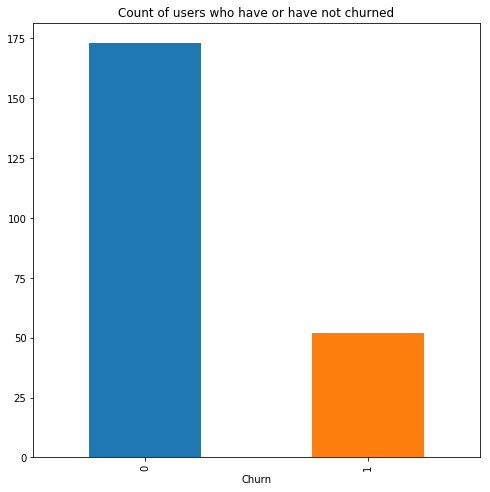

In [21]:
df.dropDuplicates(['userId']).toPandas()['churn'].value_counts().plot(kind='bar', figsize=(8,8))
plt.xlabel('Churn')
plt.title('Count of users who have or have not churned')
plt.show()

In [22]:
print("From the total users it looks like " + str(df.dropDuplicates(['userId']).toPandas()['churn'].value_counts()[1]) + " users churned")

From the total users it looks like 52 users churned


In [23]:
df.filter(df.churn == 1).agg(avg(col('length'))).show()
df.filter(df.churn == 0).agg(avg(col('length'))).show()

+------------------+
|       avg(length)|
+------------------+
|248.63279564406366|
+------------------+

+------------------+
|       avg(length)|
+------------------+
|249.20913538881427|
+------------------+



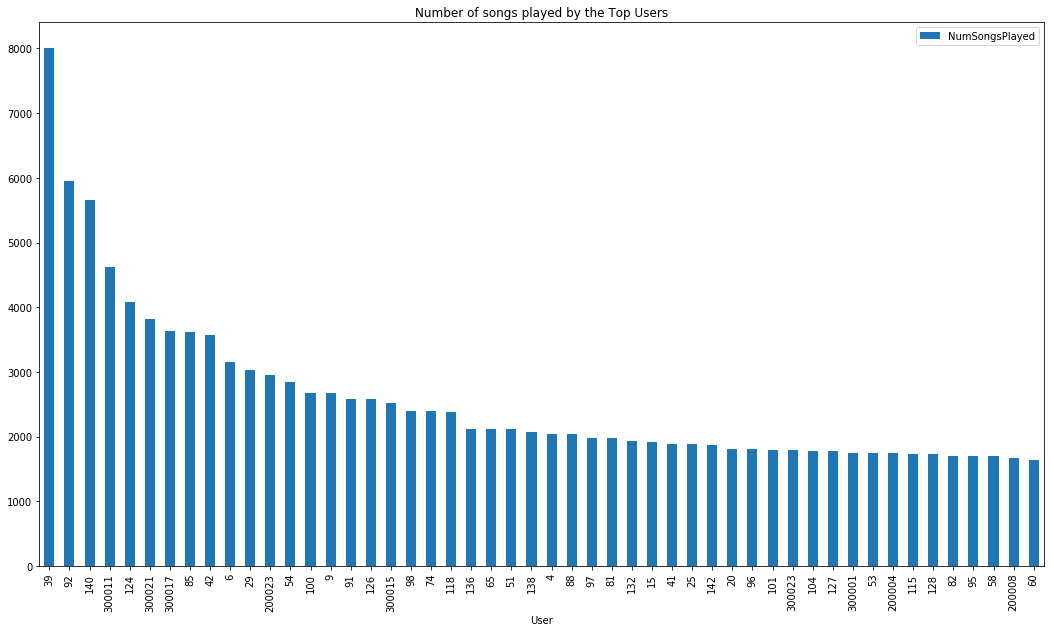

In [24]:
songs_df = df.filter(df.song != 'null').groupby('userId').agg(count(df.song).alias('NumSongsPlayed')).orderBy('NumSongsPlayed', ascending=False)
songs_df.toPandas().nlargest(50, 'NumSongsPlayed').plot(x='userId', kind='bar', figsize=(18,10))
plt.xlabel('User')
plt.title('Number of songs played by the Top Users')
plt.show()

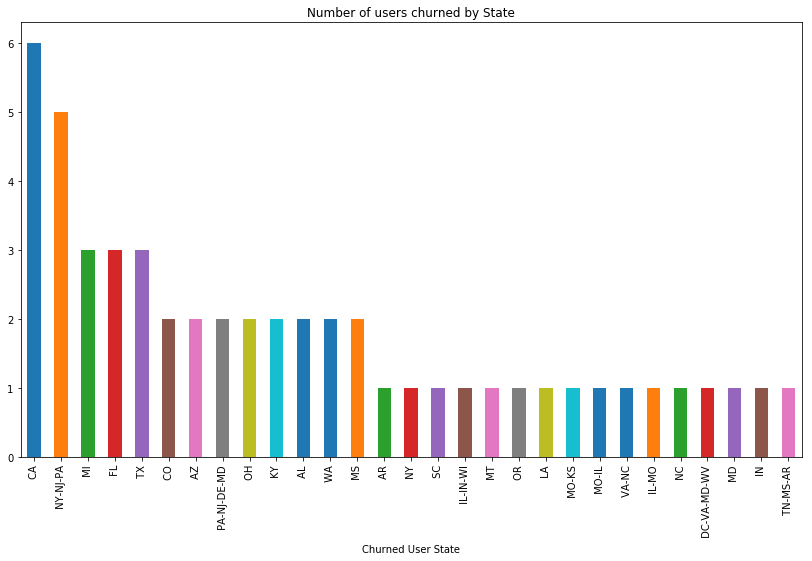

In [25]:
churned_df = df.dropDuplicates(['userId']).filter(df.churn == 1)
churned_df.toPandas()['userState'].value_counts().plot(kind='bar', figsize=(14,8))
plt.xlabel('Churned User State')
plt.title('Number of users churned by State')
plt.show()

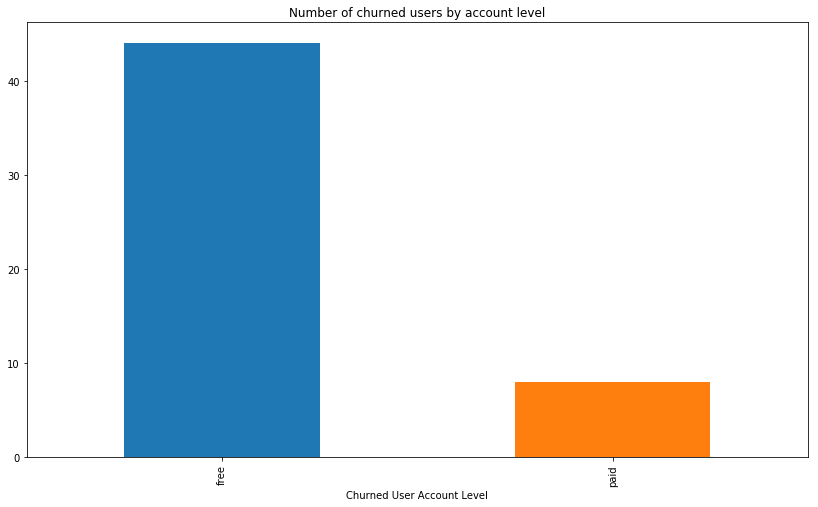

In [26]:
churned_df.toPandas()['level'].value_counts().plot(kind='bar', figsize=(14,8))
plt.xlabel('Churned User Account Level')
plt.title('Number of churned users by account level')
plt.show()

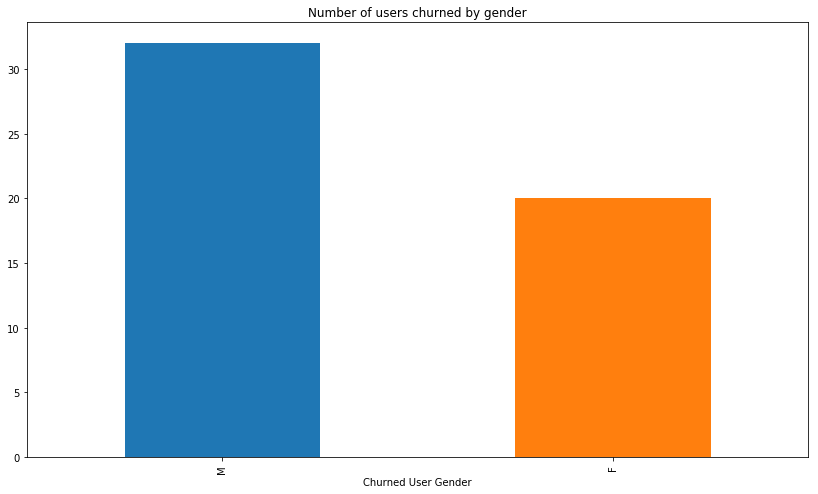

In [27]:
churned_df.toPandas()['gender'].value_counts().plot(kind='bar', figsize=(14,8))
plt.xlabel('Churned User Gender')
plt.title('Number of users churned by gender')
plt.show()

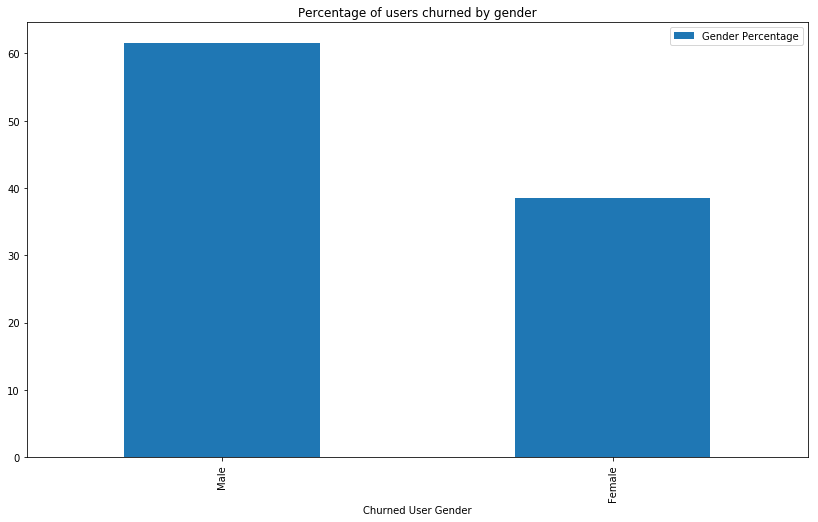

In [28]:
gender_m = churned_df.toPandas()['gender'].value_counts()[0]
gender_f = churned_df.toPandas()['gender'].value_counts()[1]
total_gender = gender_m + gender_f
gender_types = ['Male', 'Female']
gender_percentages = [(gender_m/total_gender)*100, (gender_f/total_gender)*100]
gender_percentages_df = pd.DataFrame(gender_percentages, columns=['Gender Percentage'], index=gender_types)
gender_percentages_df.plot(kind='bar', figsize=(14,8))
plt.xlabel('Churned User Gender')
plt.title('Percentage of users churned by gender')
plt.show()

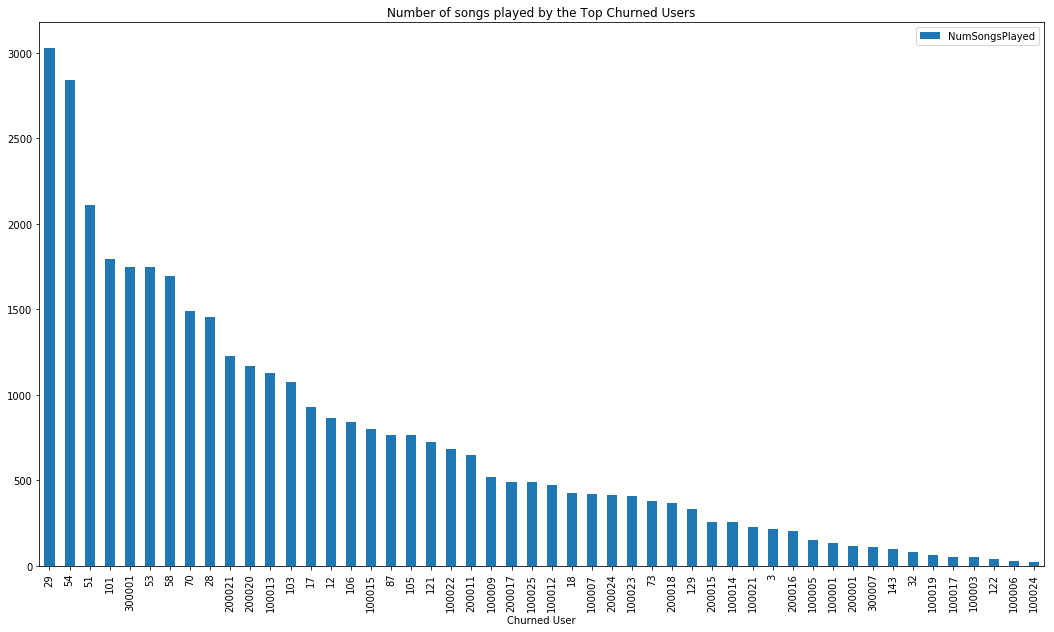

In [29]:
songs_df = df.filter(df.churn == 1).filter(df.song != 'null').groupby('userId').agg(count(df.song).alias('NumSongsPlayed')).orderBy('NumSongsPlayed', ascending=False)
songs_df.toPandas().nlargest(50, 'NumSongsPlayed').plot(x='userId', kind='bar', figsize=(18,10))
plt.xlabel('Churned User')
plt.title('Number of songs played by the Top Churned Users')
plt.show()

In [30]:
print("From the above visual, it looks like user with ID: " + str(((songs_df.toPandas().nlargest(50, 'NumSongsPlayed').userId[0]))) + " played the most songs, a total of " + str(((songs_df.toPandas().nlargest(50, 'NumSongsPlayed')).NumSongsPlayed[0])) + " but still churned")

From the above visual, it looks like user with ID: 29 played the most songs, a total of 3028 but still churned


Now that I have explored the data and have a better idea of what is in my dataset, I will use some of the data for building a model in my next steps.

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [31]:
#extract gender feature
gender_df = df.dropDuplicates(['userId']).select(['userId','gender']).replace(['M','F'], ['1', '0'])
gender_df = gender_df.withColumn('gender', gender_df.gender.cast("int"))
gender_df.show()

+------+------+
|userId|gender|
+------+------+
|100010|     0|
|200002|     1|
|   125|     1|
|   124|     0|
|    51|     1|
|     7|     1|
|    15|     1|
|    54|     0|
|   155|     0|
|100014|     1|
|   132|     0|
|   154|     0|
|   101|     1|
|    11|     0|
|   138|     1|
|300017|     0|
|100021|     1|
|    29|     1|
|    69|     0|
|   112|     1|
+------+------+
only showing top 20 rows



In [32]:
#extract level feature
level_df = df.dropDuplicates(['userId']).select(['userId','level']).replace(['paid','free'], ['1', '0'])
level_df = level_df.withColumn('level', level_df.level.cast("int"))
level_df.show()

+------+-----+
|userId|level|
+------+-----+
|100010|    0|
|200002|    0|
|   125|    0|
|   124|    1|
|    51|    1|
|     7|    0|
|    15|    1|
|    54|    1|
|   155|    0|
|100014|    1|
|   132|    0|
|   154|    0|
|   101|    0|
|    11|    0|
|   138|    0|
|300017|    1|
|100021|    0|
|    29|    0|
|    69|    0|
|   112|    0|
+------+-----+
only showing top 20 rows



In [33]:
#extract number of songs played feature
numsongsplayed_df = df.filter(df.song != 'null').groupby('userId').agg(count(df.song).alias('NumSongsPlayed')).select(['userId','NumSongsPlayed'])
numsongsplayed_df.show()

+------+--------------+
|userId|NumSongsPlayed|
+------+--------------+
|100010|           275|
|200002|           387|
|   125|             8|
|    51|          2111|
|   124|          4079|
|     7|           150|
|    54|          2841|
|    15|          1914|
|   155|           820|
|   132|          1928|
|   154|            84|
|100014|           257|
|   101|          1797|
|    11|           647|
|   138|          2070|
|300017|          3632|
|    29|          3028|
|    69|          1125|
|100021|           230|
|    42|          3573|
+------+--------------+
only showing top 20 rows



In [34]:
#extract count of friends added feature
addfriend_df = df.where(df.page=='Add Friend').groupby(['userId']).agg(count(col('page')).alias('AddFriendCount')).select(['userId','AddFriendCount'])
addfriend_df.show()

+------+--------------+
|userId|AddFriendCount|
+------+--------------+
|100010|             4|
|200002|             4|
|    51|            28|
|   124|            74|
|     7|             1|
|    54|            33|
|    15|            31|
|   155|            11|
|   132|            41|
|   154|             3|
|100014|             6|
|   101|            29|
|    11|             6|
|   138|            41|
|300017|            63|
|    29|            47|
|    69|            12|
|100021|             7|
|    42|            52|
|   112|             7|
+------+--------------+
only showing top 20 rows



In [35]:
#extract count of added to playlist feature
addtoplaylist_df = df.where(df.page=='Add to Playlist').groupby(['userId']).agg(count(col('page')).alias('AddPlaylistCount')).select(['userId','AddPlaylistCount'])
addtoplaylist_df.show()

+------+----------------+
|userId|AddPlaylistCount|
+------+----------------+
|100010|               7|
|200002|               8|
|    51|              52|
|   124|             118|
|     7|               5|
|    15|              59|
|    54|              72|
|   155|              24|
|   132|              38|
|   154|               1|
|100014|               7|
|   101|              61|
|    11|              20|
|   138|              67|
|300017|             113|
|    29|              89|
|    69|              33|
|100021|               7|
|    42|             104|
|   112|               7|
+------+----------------+
only showing top 20 rows



In [36]:
#extract count of thumbs up feature
thumbsup_df = df.where(df.page=='Thumbs Up').groupby(['userId']).agg(count(col('page')).alias('ThumbsUpCount')).select(['userId','ThumbsUpCount'])
thumbsup_df.show()

+------+-------------+
|userId|ThumbsUpCount|
+------+-------------+
|100010|           17|
|200002|           21|
|    51|          100|
|   124|          171|
|     7|            7|
|    54|          163|
|    15|           81|
|   155|           58|
|   132|           96|
|   154|           11|
|100014|           17|
|   101|           86|
|    11|           40|
|   138|           95|
|300017|          303|
|    29|          154|
|    69|           72|
|100021|           11|
|    42|          166|
|   112|            9|
+------+-------------+
only showing top 20 rows



In [37]:
#extract count of thumbs down feature
thumbsdown_df = df.where(df.page=='Thumbs Down').groupby(['userId']).agg(count(col('page')).alias('ThumbsDownCount')).select(['userId','ThumbsDownCount'])
thumbsdown_df.show()

+------+---------------+
|userId|ThumbsDownCount|
+------+---------------+
|100010|              5|
|200002|              6|
|    51|             21|
|   124|             41|
|     7|              1|
|    15|             14|
|    54|             29|
|   155|              3|
|   132|             17|
|100014|              3|
|   101|             16|
|    11|              9|
|   138|             24|
|300017|             28|
|    29|             22|
|    69|              9|
|100021|              5|
|    42|             25|
|   112|              3|
|    73|              7|
+------+---------------+
only showing top 20 rows



In [38]:
#extract number of singers feature
singers_df = df.dropDuplicates(['userId','artist']).groupby('userId').agg(count(df.artist).alias('NumSingers')).select(['userId','NumSingers'])
singers_df.show()

+------+----------+
|userId|NumSingers|
+------+----------+
|100010|       252|
|200002|       339|
|   125|         8|
|    51|      1385|
|   124|      2232|
|     7|       142|
|    15|      1302|
|    54|      1744|
|   155|       643|
|   132|      1299|
|   154|        78|
|100014|       233|
|   101|      1241|
|    11|       534|
|   138|      1332|
|300017|      2070|
|    29|      1804|
|    69|       865|
|100021|       207|
|    42|      2073|
+------+----------+
only showing top 20 rows



In [39]:
#extract total length feature
totallength_df = df.select(['userId','length']).groupBy(['userId']).sum().withColumnRenamed('sum(length)', 'TotalLength')
totallength_df.show()

+------+------------------+
|userId|       TotalLength|
+------+------------------+
|100010| 66940.89735000003|
|200002| 94008.87593999993|
|   125|2089.1131000000005|
|    51| 523275.8428000004|
|   124|1012312.0927899999|
|     7| 38034.08710000002|
|    54| 711344.9195400011|
|    15|477307.60581000015|
|   155|       198779.2919|
|   132| 483118.9038399997|
|   154|20660.023910000007|
|100014| 67703.47208000004|
|   101| 447464.0146699989|
|    11|159669.96303999983|
|   138| 512449.8827599989|
|300017| 897406.9802100015|
|    29| 754517.5625700009|
|    69| 286064.0256399999|
|100021| 57633.17563999999|
|    42| 881792.9661300007|
+------+------------------+
only showing top 20 rows



In [40]:
#combine all features into final dataframe to be used for predictive model
final_df = df.dropDuplicates(['userId']).sort('userId').select(['userId','churn'])
for feature in [gender_df,level_df,addfriend_df,addtoplaylist_df,numsongsplayed_df,thumbsup_df,thumbsdown_df,singers_df,totallength_df]:
    final_df = final_df.join(feature,'userId')

In [41]:
#rename churn to label to be used in models
final_df = final_df.withColumnRenamed("churn", "label")

In [42]:
#confirm data looks as expected
final_df.limit(5).toPandas().head()

,userId,label,gender,level,AddFriendCount,AddPlaylistCount,NumSongsPlayed,ThumbsUpCount,ThumbsDownCount,NumSingers,TotalLength
0,100010,0,0,0,4,7,275,17,5,252,6.694090e+04
1,200002,0,1,0,4,8,387,21,6,339,9.400888e+04
2,124,0,0,1,74,118,4079,171,41,2232,1.012312e+06
3,51,1,1,1,28,52,2111,100,21,1385,5.232758e+05
4,7,0,1,0,1,5,150,7,1,142,3.803409e+04


In [43]:
final_df.printSchema()

root
 |-- userId: string (nullable = true)
 |-- label: integer (nullable = false)
 |-- gender: integer (nullable = true)
 |-- level: integer (nullable = true)
 |-- AddFriendCount: long (nullable = false)
 |-- AddPlaylistCount: long (nullable = false)
 |-- NumSongsPlayed: long (nullable = false)
 |-- ThumbsUpCount: long (nullable = false)
 |-- ThumbsDownCount: long (nullable = false)
 |-- NumSingers: long (nullable = false)
 |-- TotalLength: double (nullable = true)



# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

For this step of my project, I will be building 2 base models that could possibly be used for predicting churn. Since churn is a simple churned/not-churned value, I can leverage classification models. The models I will be building are below: <br>
1. Logistic Regression Model - (https://spark.apache.org/docs/latest/api/python/pyspark.ml.html#pyspark.ml.classification.LogisticRegression) <br>
    - Base model parameters: <br>
        -maxIter: 100 <br>
        -regParam: 0.0 <br>
        -elasticNetParam: 0.0 <br>
        <br>
2. GBT Classifier Model - (https://spark.apache.org/docs/latest/api/python/pyspark.ml.html#pyspark.ml.classification.GBTClassifier) <br>
    - Base model parameters: <br>
        -maxDepth: 5 <br>
        -maxBins: 32 <br>
        -minInstancesPerNode: 1 <br>
        -minInfoGain: 0.0 <br>
        
From these models I will providing their results and evaluating their Accuracy and F1-Score. It is important for me to understand when my models are being as accurate as possible when determining when one of my users will possibly be churning and thus this is something that I will check against all models. However, Accuracy is not everything thus I must also make sure to not have a model that will potentially tell me a lot more users could possibly be churning when in reality they may not or there may be too many users showing possible churn. This could potentially lead to time wasted on users that are not churning and could mean extra costs for Sparkify. To balance this, I will be evaluating and optimizing the F1-Score which is a function of Precision and Recall to help give me the right balanced model.

In [44]:
assembler = VectorAssembler(inputCols=final_df.columns[2:],outputCol='featuresassemble')
assembler_data = assembler.transform(final_df)
scaler = StandardScaler(inputCol="featuresassemble", outputCol="features", withStd=True)
scalerModel = scaler.fit(assembler_data)
data = scalerModel.transform(assembler_data)

In [45]:
train, test = data.randomSplit([0.8, 0.2], seed=42)

In [46]:
lr_model = LogisticRegression()
lr_pipeline = Pipeline(stages=[assembler, scaler, lr_model])
lr_model_fit = lr_model.fit(train)
lr_results = lr_model_fit.transform(test)
lr_evaluation = MulticlassClassificationEvaluator(predictionCol="prediction")

print("Metrics for Logistic Regression model")
lr_accuracy = str(lr_evaluation.evaluate(lr_results, {lr_evaluation.metricName: "accuracy"}))
lr_f1_score = str(lr_evaluation.evaluate(lr_results, {lr_evaluation.metricName: "f1"}))
print("Accuracy: " + lr_accuracy)
print("F-1 Score: " + lr_f1_score)

Metrics for Logistic Regression model
Accuracy: 0.7
F-1 Score: 0.5764705882352941


In [47]:
gbt_model = GBTClassifier()
gbt_pipeline = Pipeline(stages=[assembler, scaler, gbt_model])
gbt_model_fit = gbt_model.fit(train)
gbt_results = gbt_model_fit.transform(test)
gbt_evaluation = MulticlassClassificationEvaluator(predictionCol="prediction")

print("Metrics for GBT Classifier model")
gbt_accuracy = str(gbt_evaluation.evaluate(gbt_results, {gbt_evaluation.metricName: "accuracy"}))
gbt_f1_score = str(gbt_evaluation.evaluate(gbt_results, {gbt_evaluation.metricName: "f1"}))
print("Accuracy: " + gbt_accuracy)
print("F-1 Score: " + gbt_f1_score)

Metrics for GBT Classifier model
Accuracy: 0.6666666666666666
F-1 Score: 0.6335403726708075


In [48]:
#combine my model results into one dataframe
model_names = ['Logistic Regression Model', 'GBT Classifer Model']
model_accuracies = [lr_accuracy, gbt_accuracy]
model_f1_scores = [lr_f1_score, gbt_f1_score]
model_results_df = pd.DataFrame(list(zip(model_accuracies,model_f1_scores)), index=model_names, columns=['Accuracy','F1_Score'])
model_results_df.head()

,Accuracy,F1_Score
Logistic Regression Model,0.7,0.5764705882352941
GBT Classifer Model,0.6666666666666666,0.6335403726708075


From the models trained above, it looks like the GBTClassifer had more balance between Accuracy and F1-Score. Also, for my next steps for tuning, GBT Classifer has several options for me to tune and potentially increase my metrics more that Logistic Regressions.

Hyperparameter tuning of my GBT Classifier Model with Cross Validation <br>
These are the parameters that I will tune and evaluate: <br>

    -maxIter (10, 20, 30)
    -maxDepth (3, 5, 10, 20)
    -minInfoGain (0)
    -minInstancesPerNode (1)

In [51]:
start = time.time()
gbt_param_grid = ParamGridBuilder().addGrid(gbt_model.maxIter, [10, 20, 30]).addGrid(gbt_model.maxDepth, [3, 5, 10, 20]).addGrid(gbt_model.minInfoGain, [0]).addGrid(gbt_model.minInstancesPerNode, [1]).build()
gbt_cross_val = CrossValidator(estimator=gbt_model, estimatorParamMaps=gbt_param_grid, evaluator=MulticlassClassificationEvaluator(metricName='f1'))
gbt_cross_val_model = gbt_cross_val.fit(train)
gbt_tuned_results = gbt_cross_val_model.bestModel.transform(test)
gbt_tuned_evaluation = MulticlassClassificationEvaluator(predictionCol="prediction")

print("Metrics for Tuned GBT Classifier Model")
gbt_tuned_accuracy = str(gbt_tuned_evaluation.evaluate(gbt_tuned_results, {gbt_tuned_evaluation.metricName: "accuracy"}))
gbt_tuned_f1_score = str(gbt_tuned_evaluation.evaluate(gbt_tuned_results, {gbt_tuned_evaluation.metricName: "f1"}))
print("Accuracy: " + gbt_tuned_accuracy)
print("F-1 Score: " + gbt_tuned_f1_score)  
end = time.time()
print(end - start)

Metrics for Tuned GBT Classifier Model
Accuracy: 0.7333333333333333
F-1 Score: 0.6833333333333333
16610.151875257492


In [52]:
#show the parameters that were part of the best model
gbt_cross_val_model.bestModel.extractParamMap()

{Param(parent='GBTClassifier_c9aebf5c9676', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees.'): False,
 Param(parent='GBTClassifier_c9aebf5c9676', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext'): 10,
 Param(parent='GBTClassifier_c9aebf5c9676', name='featureSubsetStrategy', doc='The number of features to consider for splits at each tree node. Supported options: auto, all, onethird, sqrt, log2, (0.0-1.0], [1-n].'): 'all',
 Param(parent='GBTClassifier_c9aebf5c9676', name='featuresCol', doc='features column name'): 'features',
 Param(parent='GBTClassifier_c9aebf5c9676', name='labelCol', doc='label column name'): 'la

My GBT Classifier model has been improved! <br>
These are the parameters that worked best for my GBT Classifer after tuning. <br>
    -maxIter (20) <br>
    -maxDepth (3)<br>
    -minInfoGain (0) <br>
    -minInstancesPerNode (1)<br>

Now I have a model that has been built and tuned and I can use for evaluating whether future users may or may not churn on the Sparkify service.

## Conclusion


In this project, I was able to implement a python notebook that loads, explores, and cleans customer data which is then used to build a machine learning model that can predict customer churn. In the dataset used for the predictive models, I had 9 features (not including the churn feature nor userId). I was able to build 2 machine learning models which are 1. Logistic Regression Model and 2. GBT Classifier Model. After comparing the Accuracy and F1-Score for each model, I determined that GBT Classifier Model was best balanced for predicting customer churn.

Improvements:
I think some improvements could certainly be made to this implementation. In this particular project, I have only used subset of the data (12MB). The full dataset is 12GB which would certainly make a HUGE difference and would allow me to have a better idea on which features may be worth a serious look and which features may be more important when creating a predictive model. Although 12MB of data certainly provides enough for this initial model, there can be some inaccuracies that could have been missed. Also, in the models I created, I simply used some specific features that I thought were relevant for my model although I could have certainly used more or all the features in my final dataset and possibly have gotten a better model. I also could have tuned the model's hyperparameters more, although this would have taken a lot more time and computing power. 

Reflection:
I enjoyed working through this project as it reflected a very real example. This is certainly something that all types of customers go through where they want to make sure they can really understand their clients better and be able to have a proactive approach rather than a reactive approach when it comes to their customers leaving. As explained in previous lessons of the Udacity Nanodegree program, the most important aspect of this project as well as for any other project with lots of data, is exploring and preprocessing the data. In order to really have models that are useful in a real world example, there needs to be a lot of thinking on how you can preprocess your data to make sure you can create a dataset that is ready for training models with. With bad preprocessing, the models created may not be as effective as you might want.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.